## Variables

In [226]:
SUBJ_ID="T02S01"
NAS="tupac"
protocole="healthy_volunteers"
DIR_PATH="/NAS/"+NAS+"/protocoles/"+protocole
FS_PATH=DIR_PATH+"/FS53/"
DTI_PATH=FS_PATH+SUBJ_ID+"/dti/"
TRACTO="whole_brain_6_1500000"#"LongueFibres_SIFT"
TRACTO_RES="FOS"
MESH="lh.white.ras"
ATLAS_FA="/home/global/fsl509/data/atlases/JHU/JHU-ICBM-FA-2mm.nii.gz"
ATLAS_LABEL="/home/global/fsl509/data/atlases/JHU/JHU-ICBM-labels-2mm.nii.gz"
SUBJ_FA=DTI_PATH+"dti_finalcor_FA.nii.gz"
FDWI = DTI_PATH+"dti.nii.gz"
FBVAL = DTI_PATH+"dti.bval"
FBVEC = DTI_PATH+"dti.bvec"
SEG = DTI_PATH+"raparc+aseg.nii"

## Imports

In [292]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import ProbabilisticDirectionGetter
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.tracking.local import LocalTracking
from dipy.tracking.local import ThresholdTissueClassifier
from dipy.tracking import utils
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

from skimage import segmentation
from skimage import morphology
from skimage import measure

import numpy as np
import nipype.interfaces.mrtrix as mrt
from nibabel import trackvis as tv
from matplotlib import pyplot as plt

## Ouverture des fichiers

In [161]:
data_dwi, affine = load_nifti(FDWI)
data_fa, affine = load_nifti(SUBJ_FA)
bvals, bvecs = read_bvals_bvecs(FBVAL,FBVEC)
gtab = gradient_table(bvals,bvecs)
data_seg, affine = load_nifti(SEG)

### Creation du DTI 

In [168]:
#tenmodel = TensorModel(gtab)
#tenfit = tenmodel.fit(data)
#save_nifti(DTI_PATH+"colorfa.nii.gz",tenfit.color_fa,affine)
data_colorfa, affine = load_nifti(DTI_PATH+"colorfa.nii.gz")

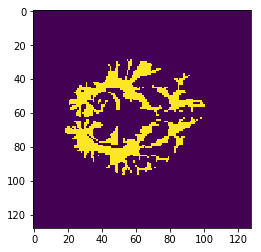

In [285]:
white_matter = ((data_seg == 41) | (data_seg == 2)) 
plt.imshow(white_matter[:,:,24])
plt.show()

# "CC" Corps Calleux

data_fa


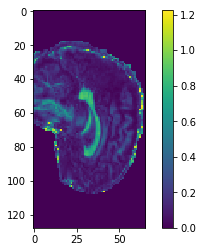

data_dwi


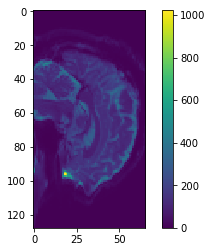

data_colorfa


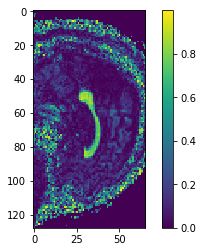

data_seg


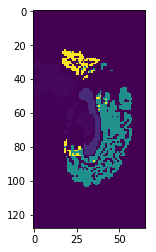

In [175]:
plt.imshow(data_fa[62,:,:])
plt.colorbar()
print("data_fa")
plt.show()
plt.imshow(data_dwi[62,:,:,0])
plt.colorbar()
print("data_dwi")
plt.show()
plt.imshow(data_colorfa[62,:,:,0])
plt.colorbar()
print("data_colorfa")
plt.show()
plt.imshow(data_seg[62,:,:])
print("data_seg")
plt.show()

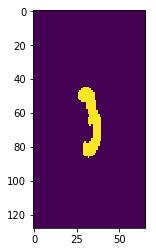

In [185]:
val=0.8
#mask = data_fa > val
mask_cc=((data_seg >= 251) & (data_seg <= 255) | (data_colorfa[:,:,:,1] > val))
filter_mask_cc = morphology.remove_small_objects(mask_cc)
#clear_image = segmentation.clear_border(filter_mask_cc)
#filter_mask_cc_f = morphology.binary_erosion(morphology.binary_dilation(filter_mask_cc))
filter_mask_cc_d = morphology.binary_dilation(filter_mask_cc);
plt.imshow(filter_mask_cc_d[62,:,:])
plt.show()
#plt.imshow(filter_mask_cc_f[62,:,:])
#plt.show()
#dilated2_a = morphology.binary_dilation(eroded_a)

In [281]:
labels = morphology.label(filter_mask_cc_d,background=0)
props = measure.regionprops(labels)
for prop in props:
    print prop.area
    print prop.bbox_area
    print prop.bbox
    print prop.centroid
    print prop.coords

1031
1081344
(59L, 45L, 26L, 65L, 87L, 40L)
(61.794374393792431, 64.156159068865179, 33.579049466537342)
[[59 81 36]
 [60 48 34]
 [60 49 34]
 ..., 
 [64 60 35]
 [64 60 36]
 [64 61 36]]


# "FOS" Faisceau Fronto Occiptal Superieur 

In [ ]:
plt.imshow(data_colorfa[:,:,24,1])
plt.colorbar()
print("data_colorfa")
plt.show()

In [ ]:
val=0.5
mask_cc=((data_seg == 41) & (data_colorfa[:,:,:,1] > val))
filter_mask_cc = morphology.remove_small_objects(mask_cc)
clear_image = segmentation.clear_border(filter_mask_cc)
#filter_mask_cc_e = morphology.binary_erosion(clear_image)
#filter_mask_cc_d = morphology.binary_dilation(filter_mask_cc_e);
plt.imshow(clear_image[:,:,24])
plt.show()
#plt.imshow(filter_mask_cc_f[62,:,:])
#plt.show()
#dilated2_a = morphology.binary_dilation(eroded_a)

In [ ]:
labels = morphology.label(clear_image,background=0)
props = measure.regionprops(labels)
for prop in props:
    print prop.area
    print prop.centroid

## Probabilistic Tracking

In [ ]:
seed_mask1=(labels==1)
seeds1 = utils.seeds_from_mask(seed_mask1, density=[2, 2, 2], affine=affine)
seed_mask2=(labels==2)
seeds2 = utils.seeds_from_mask(seed_mask2, density=[2, 2, 2], affine=affine)
seed_mask3=(labels==3)
seeds3 = utils.seeds_from_mask(seed_mask3, density=[2, 2, 2], affine=affine)
seed_mask4=(labels==4)
seeds4 = utils.seeds_from_mask(seed_mask2, density=[2, 2, 2], affine=affine)

In [ ]:
response, ratio = auto_response(gtab, data_dwi, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=6)
csd_fit = csd_model.fit(data_dwi, mask=white_matter)
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,max_angle=30.,sphere=default_sphere)

csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data_dwi, default_sphere,relative_peak_threshold=.8,min_separation_angle=45,mask=white_matter)
classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

In [ ]:
streamlines1 = LocalTracking(prob_dg, classifier, seeds1, affine,step_size=.5, max_cross=1)
streamlines2 = LocalTracking(prob_dg, classifier, seeds2, affine,step_size=.5, max_cross=1)
streamlines3 = LocalTracking(prob_dg, classifier, seeds3, affine,step_size=.5, max_cross=1)
streamlines4 = LocalTracking(prob_dg, classifier, seeds4, affine,step_size=.5, max_cross=1)

# Compute streamlines and store as a list.
streamlines1 = list(streamlines1)
streamlines2 = list(streamlines2)
streamlines3 = list(streamlines3)
streamlines4 = list(streamlines4)

In [ ]:
other_streamlines = utils.target(streamlines1, mask_cc, affine=affine,include=False)
other_streamlines = list(other_streamlines)

In [ ]:
#color = line_colors(streamlines)

r = fvtk.ren()
#streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))
#fvtk.add(r, streamlines_actor)
fvtk.add(r, fvtk.streamtube(streamlines1,fvtk.colors.white,linewidth=0.2,opacity=0.1));
fvtk.add(r, fvtk.streamtube(other_streamlines,fvtk.colors.red,linewidth=0.2,opacity=0.1));
#fvtk.add(r, fvtk.streamtube(streamlines3,fvtk.colors.green,linewidth=0.2,opacity=0.1));
#fvtk.add(r, fvtk.streamtube(streamlines3,fvtk.colors.blue,linewidth=0.2,opacity=0.1));
#fvtk.record(r, n_frames=1, out_path='probabilistic.png',size=(800, 800))
fvtk.show(r)

# Sauvegarde ROI & Tracks

In [ ]:
save_nifti(DTI_PATH+"seed_mask1.nii",seed_mask1.astype(float),affine)
#mask_cc, affine = load_nifti(DTI_PATH+"filter_mask_cc_d.nii")
#!tckedit -force -minlength 30 -include $DTI_PATH"seed_mask1.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH"seed_mask1.tck"
#!tckstats $DTI_PATH"seed_mask1.tck"
!mrview -load $SUBJ_FA -load $SUBJ_FA -tractography.load $DTI_PATH"seed_mask1.tck"

In [294]:
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data_dwi, default_sphere,relative_peak_threshold=.8,min_separation_angle=45,mask=white_matter)
seeds = utils.seeds_from_mask(filter_mask_cc_d, density=[2, 2, 2], affine=affine)
response, ratio = auto_response(gtab, data_dwi, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=6)
csd_fit = csd_model.fit(data_dwi, mask=white_matter)
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,max_angle=30.,sphere=default_sphere)
classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

In [295]:
streamlines = LocalTracking(prob_dg, classifier, seeds, affine,step_size=.5, max_cross=1)
streamlines = list(streamlines)

In [296]:
# Prepare the display objects.
color = line_colors(streamlines)

if fvtk.have_vtk:
    r = fvtk.ren()
    #streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))
    #fvtk.add(r, streamlines_actor)
    fvtk.add(r, fvtk.streamtube(streamlines,fvtk.colors.white,linewidth=0.2,opacity=0.1));
    #fvtk.record(r, n_frames=1, out_path='probabilistic.png',size=(800, 800))
    fvtk.show(r)

/home/global/anaconda2/lib/python2.7/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in divide
  orient = np.abs(orient / np.linalg.norm(orient))


## Tracks Convert & loading  

In [30]:
tck2trk = mrt.MRTrix2TrackVis()
tck2trk.inputs.in_file = DTI_PATH+TRACTO_RES+".tck"
tck2trk.inputs.image_file = DTI_PATH+"/b0.nii"
tck2trk.inputs.out_filename = DTI_PATH+TRACTO_RES+".trk"
tck2trk.run() 

170928-12:26:07,825 interface INFO:
	 Reading header data...
170928-12:26:07,825 interface INFO:
	 ...adding "100" to header for key "min_dist"
170928-12:26:07,826 interface INFO:
	 ...adding "3.0_RC2-48-gfe5084db" to header for key "mrtrix_version"
170928-12:26:07,826 interface INFO:
	 ...adding "1506593375.0725138187" to header for key "timestamp"
170928-12:26:07,827 interface INFO:
	 ...adding "include 27,8,79,10" to header for key "roi"
170928-12:26:07,827 interface INFO:
	 ...adding "include /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/occipital.nii" to header for key "roi"
170928-12:26:07,828 interface INFO:
	 ...adding "exclude /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/exclude_mask.nii" to header for key "roi"
170928-12:26:07,828 interface INFO:
	 ...adding "Float32LE" to header for key "datatype"
170928-12:26:07,829 interface INFO:
	 ...adding ". 384" to header for key "file"
170928-12:26:07,830 interface INFO:
	 ...adding "769" to header for key "cou

170928-12:26:08,14 interface INFO:
	 98% : 756 tracks read
170928-12:26:08,16 interface INFO:
	 99% : 763 tracks read
170928-12:26:08,17 interface INFO:
	 100% : 769 tracks read
170928-12:26:08,18 interface INFO:
	 Saving Trackvis file as /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/FOS.trk
170928-12:26:08,19 interface INFO:
	 TrackVis Header:
170928-12:26:08,20 interface INFO:
	 ('TRACK', [128, 128,  66], [ 2.,  2.,  2.], [ 0.,  0.,  0.], 0, ['', '', '', '', '', '', '', '', '', ''], 0, ['', '', '', '', '', '', '', '', '', ''], [[  -2.        ,    0.        ,    0.        ,  128.90971375], [   0.        ,    2.        ,    0.        , -112.26898193], [   0.        ,    0.        ,    2.        ,   -6.61752319], [   0.        ,    0.        ,    0.        ,    1.        ]], '', 'LAS', '', [ 0.,  0.,  0.,  0.,  0.,  0.], '', '', '', '', '', '', '', 769, 2, 1000)


In [187]:
streams, hdr = tv.read(DTI_PATH+TRACTO+".trk")
streamlines = [i[0] for i in streams]

Avec trk et dipy

In [214]:
cc_streamlines = utils.target(streamlines, filter_mask_cc_d,affine=affine)
cc_streamlines = list(cc_streamlines)

other_streamlines = utils.target(streamlines, filter_mask_cc_d, affine=affine,include=False)
other_streamlines = list(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

ValueError: streamlines points are outside of target_mask

Avec tck mrview etc...

In [233]:
!echo "mri_extract_label $SEG 253 $DTI_PATH"cc_mrtrix253.nii""
#!tckedit -force -minlength 50 -include $DTI_PATH"cc_mrtrix253.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH"cc_mrtrix253.tck"
!tckstats $DTI_PATH"cc_mrtrix253.tck"
#!mrview -load $SUBJ_FA -tractography.load $DTI_PATH"cc_mrtrix253.tck"

mri_extract_label /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/raparc+aseg.nii 253 /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/cc_mrtrix253.nii
tckstats: [100%] Reading track file
         mean       median    std. dev.          min          max       count
       118.93      115.849      32.6835      50.0209      200.333        27719


In [259]:
#test= filter_mask_cc_d > 9999999
#test[62,:,:]=filter_mask_cc_d[62,:,:]
save_nifti(DTI_PATH+"filter_mask_cc_d.nii",filter_mask_cc_d.astype(float),affine)
!tckedit -force -minlength 50 -include $DTI_PATH"filter_mask_cc_d.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH"CC.tck"
!tckstats $DTI_PATH"CC.tck"

#!mri_extract_label $DTI_PATH"raparc+aseg.nii" 46 47 7 8 15 16 $DTI_PATH"exclude_mask.nii"
!mri_extract_label $SEG 251 252 253 254 255 $DTI_PATH"cc_mrtrix.nii"
!tckedit -force -minlength 50 -include $DTI_PATH"cc_mrtrix.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH"CC_mrtrix.tck"
!tckstats $DTI_PATH"CC_mrtrix.tck"

!mrview -load $SUBJ_FA -load $DTI_PATH"filter_mask_cc_d.nii" -tractography.load $DTI_PATH"CC_mrtrix.tck" -tractography.load $DTI_PATH"CC.tck"

tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]  1500000 read,   205494 written
tckstats: [100%] Reading track file
         mean       median    std. dev.          min          max       count
      127.375      120.955      39.7602      50.0013      200.333       205494
reading volume from /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/raparc+aseg.nii...
extracting label 251 (CC_Posterior)
extracting label 252 (CC_Mid_Posterior)
extracting label 253 (CC_Central)
extracting label 254 (CC_Mid_Anterior)
extracting label 255 (CC_Anterior)
writing output to /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/cc_mrtrix.nii.
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]  1500000 read,   180667 written
tckstats: [100%] Reading track file
         mean       median    std. dev.          min          max       count
      129.959      123.176       38.386      50.0146      200.333       180667


In [34]:
!tckedit -force -include 27,8,79,10 -minlength 100 -exclude $DTI_PATH"exclude_mask.nii" -include $DTI_PATH"occipital.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH$TRACTO_RES".tck"
!mrview $SUBJ_FA -tractography.load $DTI_PATH$TRACTO_RES".tck"

## Génération de fibre par mrtrix

Creation du fichier r5tt.nii (pour le visualiser : r5ttvis.nii)...

In [264]:
!5ttgen freesurfer -force $DTIraparc+aseg.nii $DTI"r5tt.nii"
#!5tt2vis -force $DTI"r5tt.nii" $DTI"r5ttvis.nii"

5ttgen: 
5ttgen: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
5ttgen: 
5ttgen: Generated temporary directory: /home/romain/5ttgen-tmp-8PJKZO/
Command:  mrconvert /home/romain/raparc+aseg.nii /home/romain/5ttgen-tmp-8PJKZO/input.mif
5ttgen: 
5ttgen: [ERROR] Command failed: mrconvert /home/romain/raparc+aseg.nii /home/romain/5ttgen-tmp-8PJKZO/input.mif (freesurfer.py:20)
5ttgen: Output of failed command:
mrconvert: [ERROR] cannot stat file "/home/romain/raparc+aseg.nii": No such file or directory
mrconvert: [ERROR] error opening image "/home/romain/raparc+aseg.nii"
5ttgen: Changing back to original directory (/home/romain)
5ttgen: Script failed while executing the command: mrconvert /home/romain/raparc+aseg.nii /home/romain/5ttgen-tmp-8PJKZO/input.mif
5ttgen: For debugging, inspect contents of temporary directory: /home/romain/5ttgen-tmp-8PJKZO/


In [267]:
!tckgen -force -algorithm iFOD2 -select 1000 -seed_image dti/cc_mrtrix.nii -act dti/r5tt.nii dti/CSD6.mif dti/CC_mrtrix_gen1000.tck 
!tckgen -force -algorithm iFOD2 -select 10000 -seed_image dti/cc_mrtrix.nii -act dti/r5tt.nii dti/CSD6.mif dti/CC_mrtrix_gen10000.tck 
!tckgen -force -algorithm iFOD2 -select 100000 -seed_image dti/cc_mrtrix.nii -act dti/r5tt.nii dti/CSD6.mif dti/CC_mrtrix_gen100000.tck 
!mrview $SUBJ_FA -tractography.load $DTI_PATH"CC_mrtrix_gen1000.tck" $DTI_PATH"CC_mrtrix_gen10000.tck" $DTI_PATH"CC_mrtrix_gen10000.tck"

SyntaxError: invalid syntax (<ipython-input-267-4baa04125be0>, line 2)

### Recalage de l'atlas JHU
### et application de la transformation inverse au fibre

In [4]:
!fsl_reg {SUBJ_FA} {ATLAS_FA} {DTI_PATH}"FA_FSLreg.nii.gz" -FA -a
#!convert_xfm -omat {DTI_PATH}"FA_FSLreg_inv.nii.gz.mat" -inverse {DTI_PATH}"FA_FSLreg.nii.gz.mat"
#!invwarp -w {DTI_PATH}"FA_FSLreg.nii.gz_warp.nii.gz" -o {DTI_PATH}"JHU_labels_warp.nii.gz" -r {SUBJ_FA}
#!applywarp -i {ATLAS_LABEL} -o {DTI_PATH}"JHU_labels_native.nii.gz" -r {SUBJ_FA} -w {DTI_PATH}"JHU_labels_warp.nii.gz" -d float -s --superlevel=a --interp=nn

In [27]:
input = np.loadtxt(DTI_PATH+"FA_FSLreg.nii.gz.mat")
FOS_R=np.array([-38,-31,-3,1])
print(input)
print(FOS_R)
print (input.dot(FOS_R))

[[  9.44856887e-01   3.77739821e-02   7.33996509e-02  -3.60883849e+01]
 [ -4.66737996e-02   9.24768247e-01   1.52925770e-01  -7.38896878e+00]
 [ -5.86162655e-02  -1.64161370e-01   1.01726950e+00   4.85751836e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[-38 -31  -3   1]
[-73.38413898 -34.74195735  52.83979571   1.        ]


In [45]:
!mri_extract_label $DTI_PATH"raparc+aseg.nii" 1021 1005 1011 1013 1025 2021 2005 2011 2013 2025 $DTI_PATH"occipital.nii"

reading volume from /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/raparc+aseg.nii...
extracting label 1021 ()
extracting label 1005 ()
extracting label 1011 ()
extracting label 1013 ()
extracting label 1025 ()
extracting label 2021 ()
extracting label 2005 ()
extracting label 2011 ()
extracting label 2013 ()
extracting label 2025 ()
writing output to /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/occipital.nii.


### Visu par Dipy

In [43]:
#Faisceaux de projection
#46  Right-Cerebellum-White-Matter           220 248 164 0
#47  Right-Cerebellum-Cortex                 230 148 34  0
#7   Left-Cerebellum-White-Matter            220 248 164 0
#8   Left-Cerebellum-Cortex                  230 148 34  0
#15  4th-Ventricle                           42  204 164 0
#16  Brain-Stem                              119 159 176 0

#Commissures
#251 CC_Posterior                            0   0   64  0
#252 CC_Mid_Posterior                        0   0   112 0
#253 CC_Central                              0   0   160 0
#254 CC_Mid_Anterior                         0   0   208 0
#255 CC_Anterior                             0   0   255 0

!mri_extract_label $DTI_PATH"raparc+aseg.nii" 46 47 7 8 15 16 251 252 253 254 255 $DTI_PATH"exclude_mask.nii"

reading volume from /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/raparc+aseg.nii...
extracting label 46 (Right_Cerebellum_White_Matter)
extracting label 47 (Right_Cerebellum_Cortex)
extracting label 7 (Left_Cerebellum_White_Matter)
extracting label 8 (Left_Cerebellum_Cortex)
extracting label 15 (Fourth_Ventricle)
extracting label 16 (Brain_Stem)
extracting label 251 (CC_Posterior)
extracting label 252 (CC_Mid_Posterior)
extracting label 253 (CC_Central)
extracting label 254 (CC_Mid_Anterior)
extracting label 255 (CC_Anterior)
writing output to /NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/exclude_mask.nii.
